ND

In [1]:
import numpy as np
import copy
import os
import yaml
yaml.Dumper.ignore_aliases = lambda *args : True
import utils
import matplotlib.pyplot as plt
import tqdm
import glob


import importlib
importlib.reload(utils)

<module 'utils' from '/n/home12/cfpark00/ML/ToyCompDiff/utils.py'>

In [2]:
def get_ntr_ntest(ns,n_per=128,method="fid_axis"):
    indsgrid=np.stack(np.meshgrid(*([np.arange(n) for n in ns]),indexing="ij"),axis=-1)
    if method=="fid_axis":
        n_nonzero=np.sum(indsgrid!=0,axis=-1)
        sel=(n_nonzero<=1).flatten().astype(int)
        ntr=(sel*n_per).tolist()
        ntest=((1-sel)*n_per).tolist()
    else:
        raise ValueError("Unknown method")
    return ntr,ntest

In [3]:
config={
    'experiment_directory': None,
    'seed': None,
    "dataset":"images_1",
    'n_samples_train':[],
    'n_samples_test':[],
    'n_samples_train_gen':[],
    'n_samples_test_gen':[],
    "data_params":{
        "n_classes":64,
        "image_size": 32,
        "noise_level": 0.001,
        "comp_dims":{"shape":None,"x":None,"y":None,"color":2,"size":2,"bg_color":2},
        
        #"shape":{"names":["circle","triangle"]},#will default to circle
        "x":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "y":{"min":-0.5,"max":0.5,"n":None,"s":0.05,"s_n":0.0},
        "color":{"means":[[0.9,0.1,0.1],[0.1,0.1,0.9]],"mins":[[0.8,0.0,0.0],[0.0,0.0,0.8]],"maxs":[[1.0,0.2,0.2],[0.2,0.2,1.0]],"s_n":0.0},
        "size":{"means":[0.6,0.2],"mins":[0.52,0.12],"maxs":[0.68,0.28],"s_n":0.00,"min":0.1},
        "bg_color":{"means":[[0.9,0.9,0.9],[0.1,0.1,0.1]],"mins":[[0.8,0.8,0.8],[0.0,0.0,0.0]],"maxs":[[1.0,1.0,1.0],[0.2,0.2,0.2]],"s_n":0.0},
    },
    "model_params":{
        "model_type": "VDiff",
        "optimizer_type": "AdamW",
        "optimizer_params": {"lr": 0.001,"weight_decay": 0.01},
        "data_noise":1e-3,
        "p_cfg":None,
        "w_cfg":None,
        "beta_settings": {"type":"logsnr","noise_schedule":"learned_linear","gamma_min":-5., "gamma_max":10.},
        "network_params": {"mid_attn":True,
                           "v_conditioning_type":"sep_mlp",
                           "v_conditioning_dims":[11],
                           "chs": [64,128,256],
                           "num_res_blocks":2,
                           "init_scale":1.0},
    },
    "batch_size": 64,
    "train_ratio": 0.85,
    'num_steps': 20_000,
    'save_steps_start': 100,
    'save_steps': 60,

    "fig_n_col": 4,
}

2x2

In [4]:
ntr,ntest=get_ntr_ntest([2,2],n_per=2048,method="fid_axis")
ntr_gen,ntest_gen=get_ntr_ntest([2,2],n_per=32,method="fid_axis")
np.sum(ntr),np.sum(ntest),np.sum(ntr_gen),np.sum(ntest_gen)

(6144, 2048, 96, 32)

In [5]:
hss=0.1
0.45-(7/4)*hss

0.275

In [7]:
def get_config(sep_col=0.8,sep_size=0.4,seed=0,sc=None,ss=None):
    assert sep_col<=0.8 and sep_size<=0.4
    config_=copy.deepcopy(config)
    config_["seed"]=seed

    config_["data_params"]["n_classes"]=4
    config_["data_params"]["comp_dims"]["bg_color"]=None
    #color
    hsc=sep_col/2
    config_["data_params"]["color"]["means"]=[[0.5+hsc,0.5-hsc,0.5-hsc],[0.5-hsc,0.5-hsc,0.5+hsc]]
    if sc is not None:
        s=sc
        assert s<sep_col/2
        assert 0.5-hsc-s>=0 and 0.5+hsc+s<=1
    else:
        s=sep_col/8
    config_["data_params"]["color"]["mins"]=[[0.5+hsc-s,0.5-hsc-s,0.5-hsc-s],[0.5-hsc-s,0.5-hsc-s,0.5+hsc-s]]
    config_["data_params"]["color"]["maxs"]=[[0.5+hsc+s,0.5-hsc+s,0.5-hsc+s],[0.5-hsc+s,0.5-hsc+s,0.5+hsc+s]]
    #size
    hss=sep_size/2
    config_["data_params"]["size"]["means"]=[0.45+hss,0.45-hss]
    if ss is not None:
        s=ss
        assert s<sep_size/2, f"s={s}, sep_size={sep_size}"
        assert 0.45-hss-s>=0.1 and 0.45+hss+s<=0.7
    else:
        s=sep_size*3/8
    config_["data_params"]["size"]["mins"]=[0.45+hss-s,0.45-hss-s]
    config_["data_params"]["size"]["maxs"]=[0.45+hss+s,0.45-hss+s]
    return config_

In [24]:
configs_=[]
for sep_col in [0.2,0.4,0.6,0.8]:
    for sep_size in [0.1,0.2,0.3,0.4]:
        for seed in range(5):
            fol=f"images_1/2x2_final2/sc4ss4/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [ ]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/sc4ss4/*/*.yaml")

n_proc=10
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/sc4ss4/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [14]:
configs_=[]
for sep_col in [0.2]:
    for sep_size in [0.3]:
        for seed in [4]:
            fol=f"images_1/2x2_final2/mirun_manyckpt/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_['num_steps']=40_000
            config_['save_steps_start']=50
            config_['save_steps']=200
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [7]:
configs_=[]
for sep_col in [0.2]:
    for sep_size in [0.3]:
        for seed in [4]:
            fol=f"images_1/2x2_final2/mirun_manyckpt2/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_['num_steps']=20_000
            config_['save_steps_start']=50
            config_['save_steps']=[   50,   195,   436,   773,  1205,  1733,  2356,  3075,  3889,
        4800,  4900,  4921,  4942,  4963,  4984,  5006,  5027,  5048,
        5069,  5090,  5112,  5133,  5154,  5175,  5196,  5218,  5239,
        5260,  5281,  5303,  5324,  5345,  5366,  5387,  5409,  5430,
        5451,  5472,  5493,  5515,  5536,  5557,  5578,  5600,  5621,
        5642,  5663,  5684,  5706,  5727,  5748,  5769,  5790,  5812,
        5833,  5854,  5875,  5896,  5918,  5939,  5960,  5981,  6003,
        6024,  6045,  6066,  6087,  6109,  6130,  6151,  6172,  6193,
        6215,  6236,  6257,  6278,  6300,  6321,  6342,  6363,  6384,
        6406,  6427,  6448,  6469,  6490,  6512,  6533,  6554,  6575,
        6596,  6618,  6639,  6660,  6681,  6703,  6724,  6745,  6766,
        6787,  6809,  6830,  6851,  6872,  6893,  6915,  6936,  6957,
        6978,  7000,  7000,  8114,  9312, 10592, 11954, 13398, 14925,
       16534, 18226, 20000]
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [8]:
configs_=[]
for sep_col in [0.2]:
    for sep_size in [0.3]:
        for seed in [4]:
            fol=f"images_1/2x2_final2/mirun_manyckpt3/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_['num_steps']=20_000
            config_['save_steps_start']=50
            config_['save_steps']=[   50,   153,   312,   527,   799,  1126,  1510,  1950,  2446,
        2999,  3000,  3035,  3070,  3105,  3140,  3175,  3211,  3246,
        3281,  3316,  3351,  3386,  3422,  3457,  3492,  3527,  3562,
        3597,  3633,  3668,  3703,  3738,  3773,  3809,  3844,  3879,
        3914,  3949,  3984,  4020,  4055,  4090,  4125,  4160,  4195,
        4231,  4266,  4301,  4336,  4371,  4407,  4442,  4477,  4512,
        4547,  4582,  4618,  4653,  4688,  4723,  4758,  4793,  4829,
        4864,  4899,  4934,  4969,  5005,  5040,  5075,  5110,  5145,
        5180,  5216,  5251,  5286,  5321,  5356,  5391,  5427,  5462,
        5497,  5532,  5567,  5603,  5638,  5673,  5708,  5743,  5778,
        5814,  5849,  5884,  5919,  5954,  5989,  6025,  6060,  6095,
        6130,  6165,  6201,  6236,  6271,  6306,  6341,  6376,  6412,
        6447,  6482,  6517,  6552,  6587,  6623,  6658,  6693,  6728,
        6763,  6798,  6834,  6869,  6904,  6939,  6974,  7010,  7045,
        7080,  7115,  7150,  7185,  7221,  7256,  7291,  7326,  7361,
        7396,  7432,  7467,  7502,  7537,  7572,  7608,  7643,  7678,
        7713,  7748,  7783,  7819,  7854,  7889,  7924,  7959,  7994,
        8030,  8065,  8100,  8135,  8170,  8206,  8241,  8276,  8311,
        8346,  8381,  8417,  8452,  8487,  8522,  8557,  8592,  8628,
        8663,  8698,  8733,  8768,  8804,  8839,  8874,  8909,  8944,
        8979,  9015,  9050,  9085,  9120,  9155,  9190,  9226,  9261,
        9296,  9331,  9366,  9402,  9437,  9472,  9507,  9542,  9577,
        9613,  9648,  9683,  9718,  9753,  9788,  9824,  9859,  9894,
        9929,  9964, 10000, 10001, 10942, 11926, 12952, 14021, 15132,
       16285, 17481, 18719, 20000]
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [7]:
save_steps=[   50,   140,   275,   456,   683,   955,  1273,  1636,  2044,
        2499,  2500,  2537,  2575,  2613,  2650,  2688,  2726,  2763,
        2801,  2839,  2876,  2914,  2952,  2989,  3027,  3065,  3103,
        3140,  3178,  3216,  3253,  3291,  3329,  3366,  3404,  3442,
        3479,  3517,  3555,  3592,  3630,  3668,  3706,  3743,  3781,
        3819,  3856,  3894,  3932,  3969,  4007,  4045,  4082,  4120,
        4158,  4195,  4233,  4271,  4309,  4346,  4384,  4422,  4459,
        4497,  4535,  4572,  4610,  4648,  4685,  4723,  4761,  4798,
        4836,  4874,  4912,  4949,  4987,  5025,  5062,  5100,  5138,
        5175,  5213,  5251,  5288,  5326,  5364,  5402,  5439,  5477,
        5515,  5552,  5590,  5628,  5665,  5703,  5741,  5778,  5816,
        5854,  5891,  5929,  5967,  6005,  6042,  6080,  6118,  6155,
        6193,  6231,  6268,  6306,  6344,  6381,  6419,  6457,  6494,
        6532,  6570,  6608,  6645,  6683,  6721,  6758,  6796,  6834,
        6871,  6909,  6947,  6984,  7022,  7060,  7097,  7135,  7173,
        7211,  7248,  7286,  7324,  7361,  7399,  7437,  7474,  7512,
        7550,  7587,  7625,  7663,  7701,  7738,  7776,  7814,  7851,
        7889,  7927,  7964,  8002,  8040,  8077,  8115,  8153,  8190,
        8228,  8266,  8304,  8341,  8379,  8417,  8454,  8492,  8530,
        8567,  8605,  8643,  8680,  8718,  8756,  8793,  8831,  8869,
        8907,  8944,  8982,  9020,  9057,  9095,  9133,  9170,  9208,
        9246,  9283,  9321,  9359,  9396,  9434,  9472,  9510,  9547,
        9585,  9623,  9660,  9698,  9736,  9773,  9811,  9849,  9886,
        9924,  9962, 10000, 10001, 10506, 11024, 11555, 12098, 12653,
       13221, 13801, 14394, 15000]

In [9]:
configs_=[]
for sep_col in [0.137]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/mirun_manyckpt4/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_['num_steps']=20_000
            config_['save_steps_start']=50
            config_['save_steps']=save_steps
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [9]:
save_steps=[   50,   100,   168,   254,   357,   477,   615,   770,   943,
         1134,  1341,  1567,  1810,  2070,  2348,  2643,  2956,  3286,
         3633,  3999,  4000,  4080,  4160,  4241,  4321,  4402,  4482,
         4562,  4643,  4723,  4804,  4884,  4964,  5045,  5125,  5206,
         5286,  5366,  5447,  5527,  5608,  5688,  5768,  5849,  5929,
         6010,  6090,  6170,  6251,  6331,  6412,  6492,  6572,  6653,
         6733,  6814,  6894,  6974,  7055,  7135,  7216,  7296,  7376,
         7457,  7537,  7618,  7698,  7778,  7859,  7939,  8020,  8100,
         8180,  8261,  8341,  8422,  8502,  8582,  8663,  8743,  8824,
         8904,  8984,  9065,  9145,  9226,  9306,  9386,  9467,  9547,
         9628,  9708,  9788,  9869,  9949, 10030, 10110, 10190, 10271,
        10351, 10432, 10512, 10592, 10673, 10753, 10834, 10914, 10994,
        11075, 11155, 11236, 11316, 11396, 11477, 11557, 11638, 11718,
        11798, 11879, 11959, 12040, 12120, 12201, 12281, 12361, 12442,
        12522, 12603, 12683, 12763, 12844, 12924, 13005, 13085, 13165,
        13246, 13326, 13407, 13487, 13567, 13648, 13728, 13809, 13889,
        13969, 14050, 14130, 14211, 14291, 14371, 14452, 14532, 14613,
        14693, 14773, 14854, 14934, 15015, 15095, 15175, 15256, 15336,
        15417, 15497, 15577, 15658, 15738, 15819, 15899, 15979, 16060,
        16140, 16221, 16301, 16381, 16462, 16542, 16623, 16703, 16783,
        16864, 16944, 17025, 17105, 17185, 17266, 17346, 17427, 17507,
        17587, 17668, 17748, 17829, 17909, 17989, 18070, 18150, 18231,
        18311, 18391, 18472, 18552, 18633, 18713, 18793, 18874, 18954,
        19035, 19115, 19195, 19276, 19356, 19437, 19517, 19597, 19678,
        19758, 19839, 19919, 20000, 20000, 20882, 21783, 22702, 23641,
        24598, 25575, 26570, 27585, 28618, 29671, 30742, 31833, 32943,
        34071, 35219, 36386, 37571, 38776, 40000]

In [10]:
configs_=[]
for sep_col in [0.174]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/mirun_manyckpt5/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_['num_steps']=20_000
            config_['save_steps_start']=50
            config_['save_steps']=save_steps
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [7]:
save_steps=[   50,   134,   260,   428,   636,   886,  1178,  1510,  1884,
        2299,  2300,  2338,  2377,  2416,  2454,  2493,  2532,  2570,
        2609,  2648,  2686,  2725,  2764,  2803,  2841,  2880,  2919,
        2957,  2996,  3035,  3073,  3112,  3151,  3189,  3228,  3267,
        3306,  3344,  3383,  3422,  3460,  3499,  3538,  3576,  3615,
        3654,  3692,  3731,  3770,  3809,  3847,  3886,  3925,  3963,
        4002,  4041,  4079,  4118,  4157,  4195,  4234,  4273,  4312,
        4350,  4389,  4428,  4466,  4505,  4544,  4582,  4621,  4660,
        4698,  4737,  4776,  4815,  4853,  4892,  4931,  4969,  5008,
        5047,  5085,  5124,  5163,  5202,  5240,  5279,  5318,  5356,
        5395,  5434,  5472,  5511,  5550,  5588,  5627,  5666,  5705,
        5743,  5782,  5821,  5859,  5898,  5937,  5975,  6014,  6053,
        6091,  6130,  6169,  6208,  6246,  6285,  6324,  6362,  6401,
        6440,  6478,  6517,  6556,  6594,  6633,  6672,  6711,  6749,
        6788,  6827,  6865,  6904,  6943,  6981,  7020,  7059,  7097,
        7136,  7175,  7214,  7252,  7291,  7330,  7368,  7407,  7446,
        7484,  7523,  7562,  7601,  7639,  7678,  7717,  7755,  7794,
        7833,  7871,  7910,  7949,  7987,  8026,  8065,  8104,  8142,
        8181,  8220,  8258,  8297,  8336,  8374,  8413,  8452,  8490,
        8529,  8568,  8607,  8645,  8684,  8723,  8761,  8800,  8839,
        8877,  8916,  8955,  8993,  9032,  9071,  9110,  9148,  9187,
        9226,  9264,  9303,  9342,  9380,  9419,  9458,  9496,  9535,
        9574,  9613,  9651,  9690,  9729,  9767,  9806,  9845,  9883,
        9922,  9961, 10000, 10001, 10506, 11024, 11555, 12098, 12653,
       13221, 13801, 14394, 15000]

In [8]:
configs_=[]
for sep_col in [0.174]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/mirun_manyckpt6/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["model_params"]["network_params"]["v_conditioning_type"]="common_zerolinear"
            config_['num_steps']=15_000
            config_['save_steps_start']=50
            config_['save_steps']=save_steps
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [9]:
save_steps=[   50,   137,   268,   442,   660,   921,  1226,  1574,  1965,
         2400,  2500,  2536,  2573,  2610,  2647,  2685,  2723,  2761,
         2799,  2838,  2877,  2916,  2956,  2995,  3035,  3076,  3116,
         3157,  3198,  3239,  3281,  3323,  3365,  3407,  3450,  3493,
         3536,  3580,  3623,  3667,  3711,  3756,  3801,  3846,  3891,
         3937,  3982,  4029,  4075,  4122,  4168,  4216,  4263,  4311,
         4359,  4407,  4455,  4504,  4553,  4603,  4652,  4702,  4752,
         4802,  4853,  4904,  4955,  5006,  5058,  5110,  5162,  5215,
         5267,  5320,  5374,  5427,  5481,  5535,  5589,  5644,  5699,
         5754,  5809,  5865,  5921,  5977,  6033,  6090,  6147,  6204,
         6262,  6320,  6378,  6436,  6495,  6553,  6613,  6672,  6732,
         6791,  6852,  6912,  6973,  7034,  7095,  7156,  7218,  7280,
         7342,  7405,  7468,  7531,  7594,  7658,  7722,  7786,  7850,
         7915,  7980,  8045,  8111,  8176,  8242,  8309,  8375,  8442,
         8509,  8576,  8644,  8712,  8780,  8848,  8917,  8986,  9055,
         9124,  9194,  9264,  9334,  9405,  9476,  9547,  9618,  9689,
         9761,  9833,  9906,  9978, 10051, 10124, 10198, 10272, 10346,
        10420, 10494, 10569, 10644, 10719, 10795, 10871, 10947, 11023,
        11100, 11177, 11254, 11331, 11409, 11487, 11565, 11643, 11722,
        11801, 11880, 11960, 12040, 12120, 12200, 12281, 12361, 12443,
        12524, 12606, 12688, 12770, 12852, 12935, 13018, 13101, 13185,
        13268, 13352, 13437, 13521, 13606, 13691, 13777, 13862, 13948,
        14034, 14121, 14207, 14294, 14382, 14469, 14557, 14645, 14733,
        14822, 14910, 15000]

In [17]:
configs_=[]
for sep_col in [0.2]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/mirun_manyckpt7/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["model_params"]["network_params"]["v_conditioning_type"]="common_linear"
            config_['num_steps']=15_000
            config_['save_steps_start']=50
            config_['save_steps']=save_steps
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [10]:
configs_=[]
for sep_col in [0.2]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/mirun_manyckpt8/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["model_params"]["network_params"]["v_conditioning_type"]="sep_mlp"
            config_['num_steps']=15_000
            config_['save_steps_start']=50
            config_['save_steps']=save_steps
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [10]:
configs_=[]
for sep_col in [0.6]:
    for sep_size in [0.4]:
        for seed in [0,100,200]:
            fol=f"images_1/2x2_final2/uc/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed,sc=0.05,ss=0.04)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["fig_n_col"]=2
            config_["unconditonal"]=True
            config_['num_steps']=15_000
            config_['save_steps_start']=50
            config_['save_steps']=100
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [26]:
configs_=[]
for sep_col in [0.2,0.4,0.6,0.8]:
    for sep_size in [0.1,0.2,0.3,0.4]:
        for seed in range(5):
            fol=f"images_1/2x2_final2/sc4ss4_sfixed/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed,sc=0.05,ss=0.04)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_.append(config_)

In [27]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/sc4ss4_sfixed/*/*.yaml")

n_proc=6
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/sc4ss4_sfixed/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [9]:
configs_detailed=[]
for sep_col in [0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    for sep_size in [0.2,0.233,0.266,0.3,0.333,0.366,0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/detailed/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_detailed.append(config_)

In [45]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/detailed/*/*.yaml")

n_proc=10
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/detailed/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [7]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [53]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [16]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_cfg/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=True
            config_["model_params"]["p_cfg"]=0.2
            config_["model_params"]["w_cfg"]=3.0
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [17]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_cfg/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_cfg/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [12]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_cfg_long/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=True
            config_["model_params"]["p_cfg"]=0.1
            config_["model_params"]["w_cfg"]=3.0
            config_['num_steps']= 60_000
            config_['save_steps_start']= 50
            config_['save_steps']= 120
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [13]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_cfg_long/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_cfg_long/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [7]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.247, 0.321, 0.432,  0.579, 0.726, 0.8]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_cfg_long2/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=True
            config_["model_params"]["p_cfg"]=0.1
            config_["model_params"]["w_cfg"]=3.0
            config_['num_steps']= 60_000
            config_['save_steps_start']= 50
            config_['save_steps']= 120
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [8]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_cfg_long2/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_cfg_long2/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [7]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.247, 0.321, 0.432,  0.579, 0.726, 0.8]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_cfg_long3/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=True
            config_["model_params"]["p_cfg"]=0.1
            config_["model_params"]["w_cfg"]=3.0
            config_['num_steps']= 25_000
            config_['save_steps_start']= 50
            config_['save_steps']= 80
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [8]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_cfg_long3/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_cfg_long3/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [9]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_det/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config["model_params"]["model_type"]="Det"
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [10]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_det/*/*.yaml")

n_proc=5
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_det/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [25]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_gamma1/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config["model_params"]["beta_settings"]["gamma_min"]=-14
            config["model_params"]["beta_settings"]["gamma_max"]=19
            config["save_steps_start"]=50
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [26]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_gamma1/*/*.yaml")

n_proc=5
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_gamma1/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [9]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_inis=0.1/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["model_params"]["network_params"]["init_scale"]=0.1
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [11]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_inis=0.1/*/*.yaml")

n_proc=3
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_inis=0.1/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [13]:
configs_col_sweep=[]
for sep_col in [0.1  , 0.137, 0.174, 0.211, 0.247, 0.284, 0.321, 0.358, 0.395,
0.432, 0.468, 0.505, 0.542, 0.579, 0.616, 0.653, 0.689, 0.726,
       0.763, 0.8  ]:
    for sep_size in [0.4]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/col_sweep_wd=0.05/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            #weight decay
            config_["model_params"]["optimizer_params"]["weight_decay"]=0.05
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_col_sweep.append(config_)

In [14]:
yaml_files=glob.glob("./yamls/images_1/2x2_final2/col_sweep_wd=0.05/*/*.yaml")

n_proc=3
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/col_sweep_wd=0.05/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [157]:
configs_size_sweep=[]
for sep_col in [0.4]:
    for sep_size in [0.2  , 0.211, 0.221, 0.232, 0.242, 0.253, 0.263, 0.274, 0.284,
       0.295, 0.305, 0.316, 0.326, 0.337, 0.347, 0.358, 0.368, 0.379,
       0.389, 0.4  ]:
        for seed in [0,100,200,300,400]:
            fol=f"images_1/2x2_final2/size_sweep/sep_col={sep_col}_sep_size={sep_size}"
            experiment_name=f"seed={seed}"
            config_=get_config(sep_col=sep_col,sep_size=sep_size,seed=seed)
            config_['n_samples_train']=ntr
            config_['n_samples_test']=ntest_gen #intentional
            config_['n_samples_train_gen']=ntr_gen
            config_['n_samples_test_gen']=ntest_gen
            config_["save_ckpts"]=False
            config_["fig_n_col"]=2
            config_=utils.process_config(config_,check_only=True)
            experiment_directory=os.path.join("data",fol,experiment_name)
            config_["experiment_directory"]=experiment_directory
            yaml_fol=os.path.join("yamls",fol)
            os.makedirs(yaml_fol,exist_ok=True)
            yaml_path=os.path.join(yaml_fol,experiment_name+".yaml")
            yaml.dump(config_,open(yaml_path,"w"))
            configs_size_sweep.append(config_)

In [56]:
import glob
import os
yaml_files=glob.glob("./yamls/images_1/2x2_final2/size_sweep/*/*.yaml")

n_proc=4
chunked=[yaml_files[i::n_proc] for i in range(n_proc)]
for i,chunk in enumerate(chunked):
    with open(f"./yamls/images_1/2x2_final2/size_sweep/yamls_{i}.txt","w") as f:
        for path in chunk:
            path=os.path.abspath(path)
            f.write(path+"\n")

In [28]:
#config_=configs_[3*5]
config_=configs_col_sweep[0]
config_["n_samples_train_gen"]=[32,32,32,32]
config_["n_samples_test_gen"]=[32,32,32,32]
x_tr1,y_tr1,l_tr1,x_te1,y_te1,l_te1=utils.generate_data(config_,seed=42,forgen=True)
config_=configs_col_sweep[-1]
config_["n_samples_train_gen"]=[32,32,32,32]
config_["n_samples_test_gen"]=[32,32,32,32]
x_tr2,y_tr2,l_tr2,x_te2,y_te2,l_te2=utils.generate_data(config_,seed=42,forgen=True)

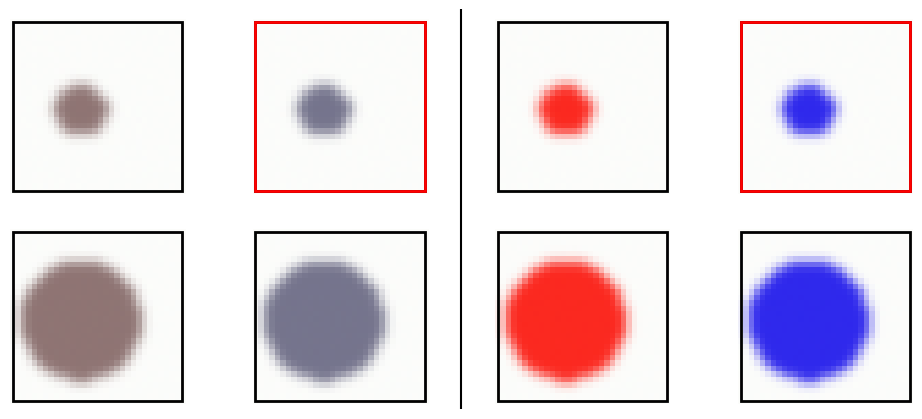

In [68]:
i=16

fig=plt.figure(figsize=(12,5))
plt.subplot(2,4,1)
plt.imshow(x_tr1[l_tr1==1][i].transpose(2,1,0))
tra1=plt.subplot(2,4,2)
plt.imshow(x_tr1[l_tr1==3][i].transpose(2,1,0))
plt.subplot(2,4,5)
plt.imshow(x_tr1[l_tr1==0][i].transpose(2,1,0))
plt.subplot(2,4,6)
plt.imshow(x_tr1[l_tr1==2][i].transpose(2,1,0))

#subplot separating line
mida=plt.gcf().add_axes([0.507,0.1,0.01,0.8],frame_on=False)
plt.axvline(0.5,0,1,color="black")

plt.subplot(2,4,3)
plt.imshow(x_tr2[l_tr2==1][i].transpose(2,1,0))
tra2=plt.subplot(2,4,4)
plt.imshow(x_tr2[l_tr2==3][i].transpose(2,1,0))
plt.subplot(2,4,7)
plt.imshow(x_tr2[l_tr2==0][i].transpose(2,1,0))
plt.subplot(2,4,8)
plt.imshow(x_tr2[l_tr2==2][i].transpose(2,1,0))

for ax in fig.get_axes():
    ax.set_axis_off()
    if ax is not mida:
        ax.add_patch(plt.Rectangle((0,0),31,31,fill=None,edgecolor="black",linewidth=2))
    ax.set_xticks([])
    ax.set_yticks([])  
    #ax.set 
tra1.add_patch(plt.Rectangle((0,0),31,31,fill=None,edgecolor="red",linewidth=2))
tra2.add_patch(plt.Rectangle((0,0),31,31,fill=None,edgecolor="red",linewidth=2))
#plt.tight_layout()
plt.savefig("./figures/final/concept_signal_sep.png",dpi=300)

In [84]:
import shutil
fols=glob.glob("./data/images_1//2x2_final2/detailed/*/*")
for fol in fols:
    yaml_path=glob.glob(os.path.join(fol,"*.yaml"))[0]
    #parent fol
    yaml_name=os.path.basename(yaml_path)
    pfolname=os.path.basename(os.path.dirname(fol))
    yaml_name_new=pfolname+"_"+yaml_name
    yaml_path_new=os.path.join("./data/to_maya/sep7xsep7/",yaml_name_new)
    assert not os.path.exists(yaml_path_new)
    shutil.copy(yaml_path,yaml_path_new)

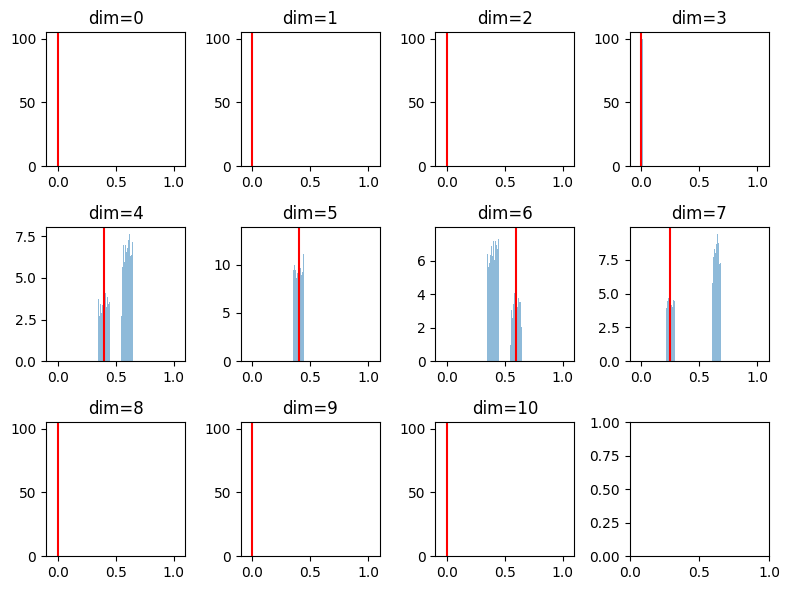

In [23]:
import matplotlib.pyplot as plt
import tqdm
fig,axs=plt.subplots(3,4,figsize=(8,6))
for dim in range(y_tr.shape[1]):
    ax=axs.flatten()[dim]
    l_te_unique=np.unique(l_te)
    y_tes=[y_te[l_te==l][0,dim] for l in l_te_unique]
    ax.hist(y_tr[:,dim],bins=100,density=True,alpha=0.5)
    for y in y_tes:
        ax.axvline(y,color="r")
    ax.set_title(f"dim={dim}")
    ax.set_xlim(-0.1,1.1)
plt.tight_layout()